In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Step 1: Load the dataset and clean unwanted columns
df = pd.read_csv("smart_deal_recommendations.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove unnamed index columns if any
if 'vehicle_type' in df.columns:
    df.drop('vehicle_type', axis=1, inplace=True)  # Drop 'vehicle_type' column as it's not needed

In [ ]:
print(df.head())

      trip_purpose travel_company current_weather  ambient_temp time_of_day  \
0  No Urgent Place          Alone           Sunny            55         2PM   
1  No Urgent Place      Friend(s)           Sunny            80        10AM   
2  No Urgent Place      Friend(s)           Sunny            80        10AM   
3  No Urgent Place      Friend(s)           Sunny            80         2PM   
4  No Urgent Place      Friend(s)           Sunny            80         2PM   

              offer_type deal_expiry_window user_gender user_age_group  \
0        Restaurant(<20)                 1d      Female             21   
1           Coffee House                 2h      Female             21   
2  Carry out & Take away                 2h      Female             21   
3           Coffee House                 2h      Female             21   
4           Coffee House                 1d      Female             21   

  relationship_status  ...  visit_cafe_freq visit_takeout_freq  \
0   Unmarried 

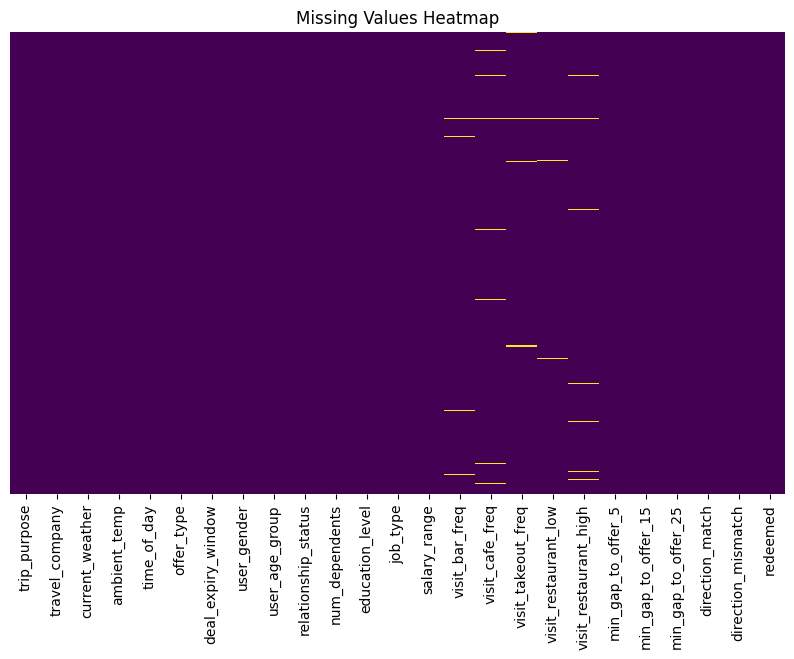

In [ ]:
# Missing values heatmap to check which columns have missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
# Step 2: Remove duplicate rows to avoid biased training
df.drop_duplicates(inplace=True)

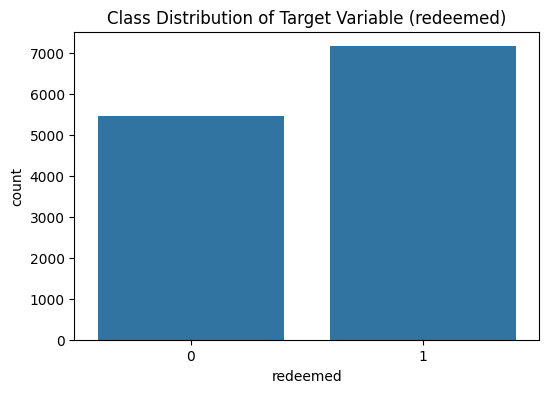

In [ ]:
# Distribution of target variable 'redeemed' to check class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='redeemed', data=df)
plt.title("Class Distribution of Target Variable (redeemed)")
plt.show()

In [ ]:
# Step 3: Separate categorical and numerical columns
cat_cols = df.select_dtypes(include='object').columns  # Categorical features
num_cols = df.select_dtypes(include=[np.number]).columns.drop("redeemed")  # Numeric features, excluding target


In [ ]:
# Step 4: Handle missing values in data
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])  # Fill missing categorical data with mode
df[num_cols] = df[num_cols].fillna(df[num_cols].median())  # Fill missing numeric data with median

In [ ]:
# Step 5: Convert categorical variables into numeric form using Label Encoding
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
# Step 6: Remove outliers using the Interquartile Range (IQR) method to improve model robustness
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [ ]:
# Step 7: Apply PowerTransformer to reduce skewness and normalize numeric features
pt = PowerTransformer()
df[num_cols] = pt.fit_transform(df[num_cols])

In [ ]:
# Step 8: Create new interaction features to capture relationships between important variables
if 'discount_percentage' in df.columns and 'coupon_percentage' in df.columns:
    df["discount_x_coupon"] = df["discount_percentage"] * df["coupon_percentage"]
if 'age' in df.columns and 'income' in df.columns:
    df["age_x_income"] = df["age"] * df["income"]

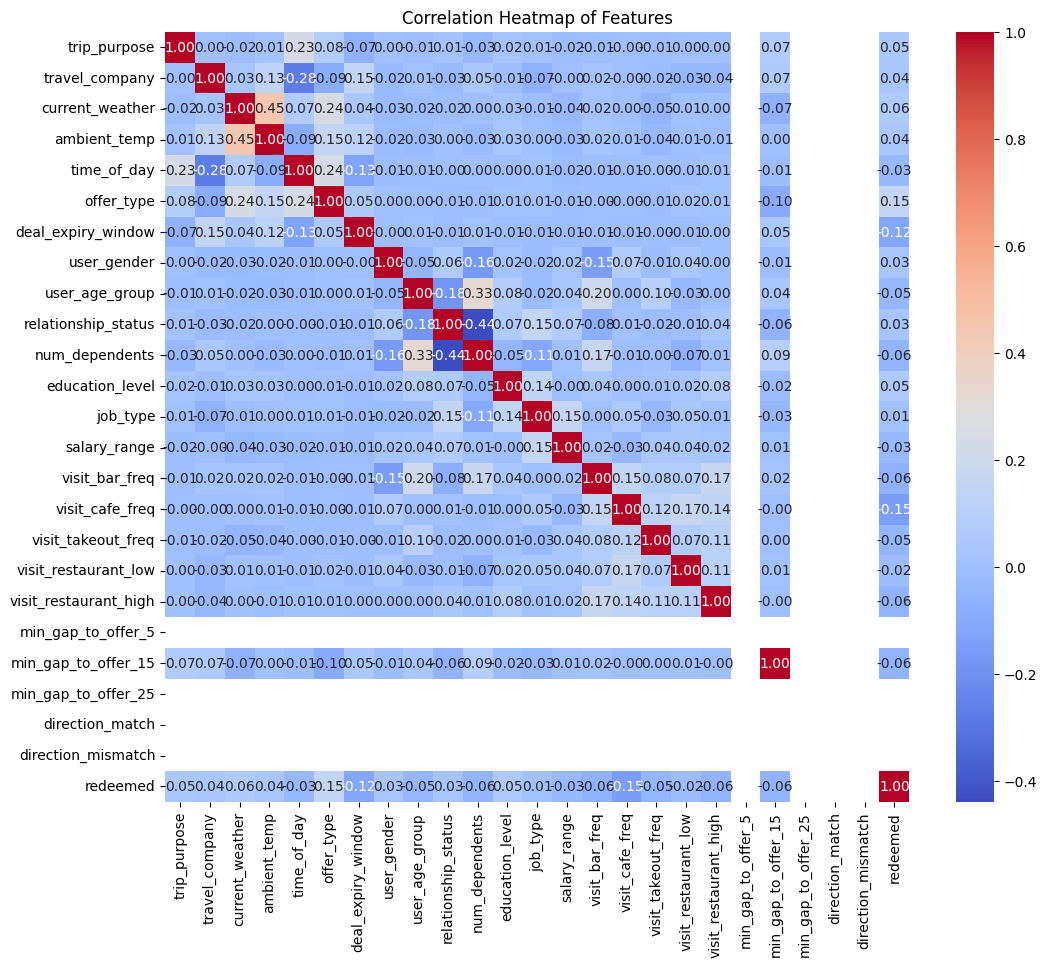

In [ ]:
# Correlation heatmap to understand relationships between features and target
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

In [ ]:
# Step 9: Separate features and target variable
X = df.drop("redeemed", axis=1)
y = df["redeemed"]

In [ ]:
# Step 10: Remove features with very low variance (almost constant) as they don't add value
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)

In [ ]:
# Step 11: Add polynomial features to help Logistic Regression model capture non-linear relationships
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X)

In [ ]:
# Step 12: Standardize the features to have zero mean and unit variance for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

In [ ]:
# Step 13: Handle class imbalance by oversampling the minority class using SMOTE technique
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [ ]:
# Step 14: Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Step 15: Select the most important 25 features using Recursive Feature Elimination with Logistic Regression
base_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
rfe = RFE(base_model, n_features_to_select=25)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)


In [ ]:
# Step 16: Tune Logistic Regression hyperparameters with GridSearchCV to find best regularization and penalty
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, cv=5)
grid.fit(X_train_rfe, y_train)

best_logreg = grid.best_estimator_

In [ ]:
# Step 17: Predict and evaluate Logistic Regression model on the test data
y_pred_log = best_logreg.predict(X_test_rfe)
print(f"\n--- Tuned Logistic Regression ---")
print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))



--- Tuned Logistic Regression ---
Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6760705289672544
ROC AUC: 0.6759351208209202
Confusion Matrix:
 [[652 326]
 [317 690]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67       978
           1       0.68      0.69      0.68      1007

    accuracy                           0.68      1985
   macro avg       0.68      0.68      0.68      1985
weighted avg       0.68      0.68      0.68      1985




--- Random Forest ---
Accuracy: 0.8136020151133502
ROC AUC: 0.8134149907701306
Confusion Matrix:
 [[783 195]
 [175 832]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       978
           1       0.81      0.83      0.82      1007

    accuracy                           0.81      1985
   macro avg       0.81      0.81      0.81      1985
weighted avg       0.81      0.81      0.81      1985



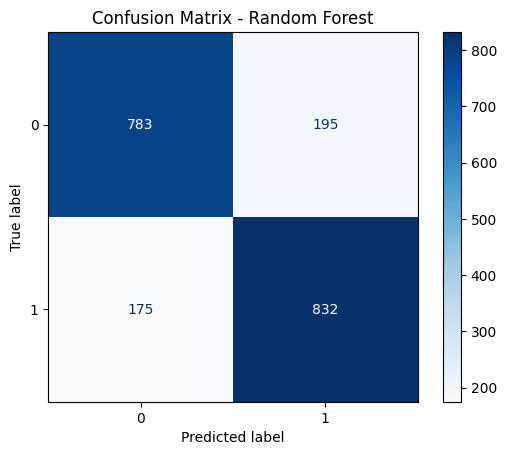


--- XGBoost ---
Accuracy: 0.8151133501259445
ROC AUC: 0.8149781793295601
Confusion Matrix:
 [[788 190]
 [177 830]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       978
           1       0.81      0.82      0.82      1007

    accuracy                           0.82      1985
   macro avg       0.82      0.81      0.82      1985
weighted avg       0.82      0.82      0.82      1985



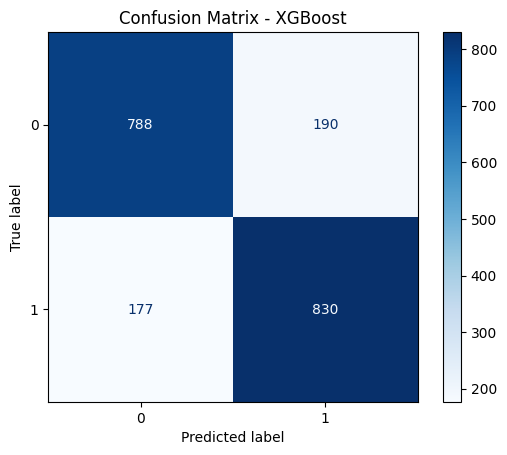

In [ ]:
# Step 18: Train and evaluate other models (Random Forest, XGBoost) on the original scaled dataset for comparison
models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=3, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, subsample=0.9,
                             colsample_bytree=0.9, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    # Confusion matrix heatmap for each model
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()